<a href="https://colab.research.google.com/github/ua-datalab/Bioinformatics/blob/main/MLFlow/Bioinformatics_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leveraging MLflow for Experiment Tracking in Bioinformatics


In [1]:
!pip install mlflow pandas scikit-learn numpy

## 1. Import Libraries

In [2]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load and Explore the Dataset

In [3]:
# Load the dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Display the first few rows
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. Data Preprocessing

In [4]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Calcualte the correlations between different columns and plot the values

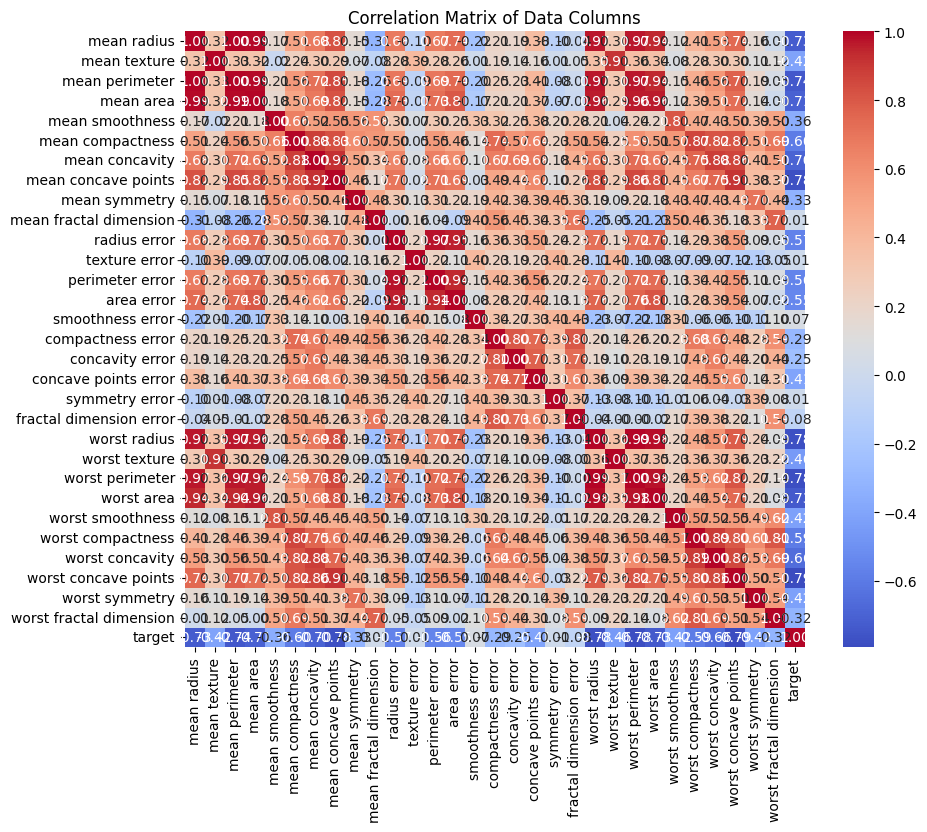

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Data Columns')
plt.show()


## 4. Set Up MLflow Experiment

In [6]:
mlflow.set_experiment("Breast_Cancer_Classification")

2024/10/25 20:28:59 INFO mlflow.tracking.fluent: Experiment with name 'Breast_Cancer_Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///workspaces/Bioinformatics/MLFlow/mlruns/107985550435718349', creation_time=1729888139082, experiment_id='107985550435718349', last_update_time=1729888139082, lifecycle_stage='active', name='Breast_Cancer_Classification', tags={}>

## 5. Define and Run Experiments

In [7]:
def run_experiment(n_estimators, max_depth):
    with mlflow.start_run():
        # Log parameters
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)

        # Log model
        mlflow.sklearn.log_model(model, "random_forest_model")

        # Log confusion matrix as an artifact
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Print metrics
        print(f"Parameters: n_estimators={n_estimators}, max_depth={max_depth}")
        print(f"Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

# Run experiments with different hyperparameters
n_estimators_list = [50, 100, 150]
max_depth_list = [5, 10, 15]

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        run_experiment(n_estimators, max_depth)

2024/10/25 20:29:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=50, max_depth=5
Accuracy: 0.9561, ROC AUC: 0.9937


2024/10/25 20:29:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=50, max_depth=10
Accuracy: 0.9561, ROC AUC: 0.9919


2024/10/25 20:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=50, max_depth=15
Accuracy: 0.9561, ROC AUC: 0.9919


2024/10/25 20:29:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=100, max_depth=5
Accuracy: 0.9561, ROC AUC: 0.9934


2024/10/25 20:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=100, max_depth=10
Accuracy: 0.9561, ROC AUC: 0.9939


2024/10/25 20:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=100, max_depth=15
Accuracy: 0.9561, ROC AUC: 0.9939


2024/10/25 20:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=150, max_depth=5
Accuracy: 0.9474, ROC AUC: 0.9931


2024/10/25 20:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=150, max_depth=10
Accuracy: 0.9561, ROC AUC: 0.9931


2024/10/25 20:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=150, max_depth=15
Accuracy: 0.9561, ROC AUC: 0.9929


## 6. Viewing Experiment Results

In [8]:
# Retrieve experiment ID
experiment_id = mlflow.get_experiment_by_name("Breast_Cancer_Classification").experiment_id

# Fetch all runs from the experiment
runs = mlflow.search_runs(experiment_ids=experiment_id)

# Display the runs
runs_df = runs[["run_id", "params.n_estimators", "params.max_depth", "metrics.accuracy", "metrics.roc_auc"]]
runs_df.sort_values(by="metrics.roc_auc", ascending=False, inplace=True)
runs_df.reset_index(drop=True, inplace=True)
runs_df

/tmp/ipykernel_1768/892939034.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_df.sort_values(by="metrics.roc_auc", ascending=False, inplace=True)


,run_id,params.n_estimators,params.max_depth,metrics.accuracy,metrics.roc_auc
0,566212aefbb24d31be053bec97cdeed8,100,10,0.956140,0.993882
1,bf391a105b9742939742fa374240afcd,100,15,0.956140,0.993882
2,e05eca2613454ac189b0fd4f22fabd08,50,5,0.956140,0.993717
3,aaff7440eebf470a8f0289673b493936,100,5,0.956140,0.993386
4,fdad7e9e2f0244e98125321a22b505af,150,10,0.956140,0.993056
5,58faa12f395749ee89deb4d746462b41,150,5,0.947368,0.993056
6,272d8e0e107a4745b5f105a3ba10f377,150,15,0.956140,0.992890
7,badfca64886846ff8ea0d0c56d925d08,50,15,0.956140,0.991898
8,d7e651b2a2ac42869de335756b7f9f93,50,10,0.956140,0.991898


## 7. Analyze Results

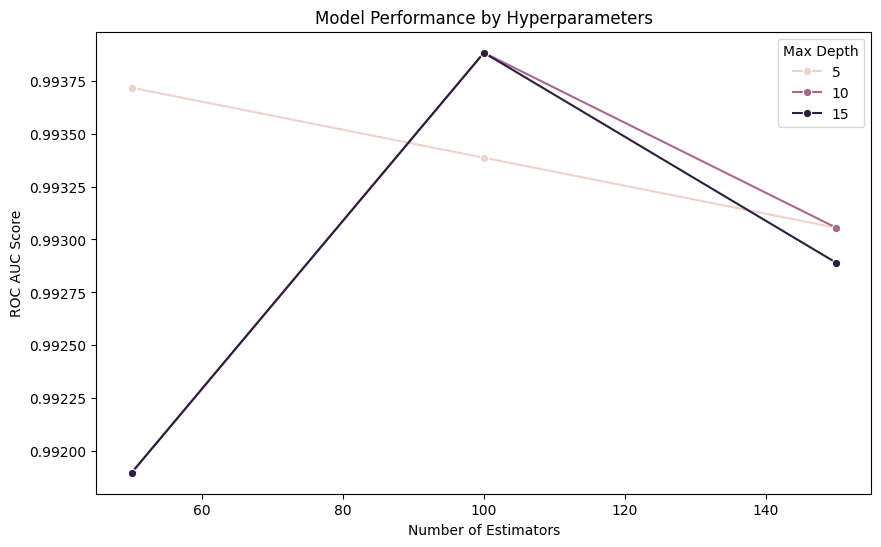

In [10]:
# Convert parameter columns to numeric
runs_df.loc[:, 'params.n_estimators'] = runs_df['params.n_estimators'].astype(int)
runs_df.loc[:, 'params.max_depth'] = runs_df['params.max_depth'].astype(int)

# Plot performance
plt.figure(figsize=(10,6))
sns.lineplot(data=runs_df, x='params.n_estimators', y='metrics.roc_auc', hue='params.max_depth', marker='o')
plt.title('Model Performance by Hyperparameters')
plt.xlabel('Number of Estimators')
plt.ylabel('ROC AUC Score')
plt.legend(title='Max Depth')
plt.show()

## 8. Load and Evaluate the Best Model

In [11]:
# Get the best run ID
best_run_id = runs_df.iloc[0]['run_id']

# Load the model
best_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/random_forest_model")

# Make predictions
y_pred_best = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

